### 不同细胞亚型得scRNA数据，需要改变输入和输出路径

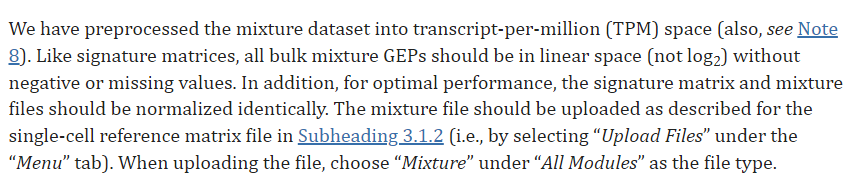

CibersortX文章（https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7695353/） 提示输入数据是芯片数据还是Bulk RNA-seq数据都可以，Bulk RNA-seq数据不建议直接使用Count，应使用FPKM或DESEq2标准化后，**特别是TPM的矩阵为宜，没有负值或缺失值**

In [18]:
library(Seurat)
library(dplyr)
# library(IOBR)
library(readr)
library(data.table)
library(stringr)
library(qs)

In [19]:
#IOBR安装！
# install.packages("remotes")
# remotes::install_github("ropensci/magick") #  DONE (magick)
# 或者micromamba install -c conda-forge r-magick -y

# remotes::install_github("drighelli/SpatialExperiment") #DONE (SpatialExperiment)
# remotes::install_github("rcastelo/GSVA")#  DONE (GSVA)
# devtools::install_github("IOBR/IOBR") # * DONE (IOBR)


# '''
# 只有转换基因 ENSG ID转为Gene symbol ID 的时候才用到
# geneID = IOBR::anno_rnaseq
# head(geneID)
# '''

### Step1.读入数据

scRNA-seq单细胞数据+Bulk RNA-seq矩阵

In [48]:
## 1.1 单细胞数据
seurat.data = qread(file = "/home/guoliming/Brown/ALI_CRL/ALI/Endothelial/Outdata/Sub_End_annotion.qs")

In [49]:
table(seurat.data$celltype)


Endothelial_c0 Endothelial_c1 Endothelial_c2 Endothelial_c3 Endothelial_c4 
           895            462            409            287            135 
Endothelial_c5 Endothelial_c6 Endothelial_c7 Endothelial_c8 Endothelial_c9 
           118            114             95             58             44 

### Step2.从Seurat对象中制作单细胞表达矩阵（行为基因，列为细胞）

由于单细胞数据太大，而CibersortX最多只支持1Gb的文件输入,因此需要我们对单细胞数据进行抽样

In [50]:
## 2.1 对cell.type进行抽样
Idents(seurat.data) = "celltype"

In [51]:
seurat.data

An object of class Seurat 
34329 features across 2617 samples within 1 assay 
Active assay: RNA (34329 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, umap, harmony

In [52]:
seurat.data.sub = subset(seurat.data, downsample = 10000)

In [53]:
seurat.data.sub

An object of class Seurat 
34329 features across 2617 samples within 1 assay 
Active assay: RNA (34329 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, umap, harmony

In [54]:
## 2.2 获得矩阵
exp_matrix = as.data.frame(seurat.data.sub@assays$RNA@counts) #表达矩阵

In [55]:
exp_matrix[1:3,1:12]

,GSM8504081_AAAGAACAGACCATAA-1,GSM8504081_AAAGGGCGTTTCCCAC-1,GSM8504081_AAAGTGAGTGATTAGA-1,GSM8504081_AAAGTGAGTTTCGGCG-1,GSM8504081_AAATGGATCCATCAGA-1,GSM8504081_AACAAGATCGAGTACT-1,GSM8504081_AACACACTCCAATGCA-1,GSM8504081_AACCAACAGCTGACAG-1,GSM8504081_AACCAACAGTGTAGAT-1,GSM8504081_AACCAACGTTGCCAAT-1,GSM8504081_AACCACACATGATAGA-1,GSM8504081_AACCATGAGTATTGCC-1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xkr4,0,0,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,0,0


##### 基因名改大写的情况

In [56]:
# # 将行名改为大写
# new_rownames <- toupper(rownames(exp_matrix))

# # 如果有重复，添加序号后缀
# new_rownames <- make.unique(new_rownames)

# # 设置为行名
# rownames(exp_matrix) <- new_rownames

# # 添加 GeneSymbol 列（原始大写名，不加序号）
# exp_matrix$GeneSymbol <- toupper(rownames(seurat.data.sub@assays$RNA@counts))

# # 可选：把 GeneSymbol 列放到最前面
# exp_matrix <- cbind(GeneSymbol = exp_matrix$GeneSymbol, exp_matrix[, -ncol(exp_matrix)])

##### 基因名不改大写的情况

In [57]:
# 将行名改为大写
new_rownames <- rownames(exp_matrix)

# 如果有重复，添加序号后缀
new_rownames <- make.unique(new_rownames)

# 设置为行名
rownames(exp_matrix) <- new_rownames

# 添加 GeneSymbol 列（原始大写名，不加序号）
exp_matrix$GeneSymbol <- rownames(seurat.data.sub@assays$RNA@counts)

# 可选：把 GeneSymbol 列放到最前面
exp_matrix <- cbind(GeneSymbol = exp_matrix$GeneSymbol, exp_matrix[, -ncol(exp_matrix)])

In [58]:
exp_matrix = exp_matrix[!duplicated(exp_matrix$GeneSymbol),]

In [59]:
table(duplicated(exp_matrix$GeneSymbol))


FALSE 
34329 

In [60]:
cell_names = seurat.data.sub@meta.data$celltype #细胞名称
colnames(exp_matrix)[-1] = cell_names#细胞名命名矩阵列明
head(colnames(exp_matrix))

[1] "GeneSymbol"     "Endothelial_c0" "Endothelial_c2" "Endothelial_c2"
[5] "Endothelial_c2" "Endothelial_c0"

In [61]:
## 2.3 输出文件
fwrite(exp_matrix,file = "Endothelial_scRNA.txt",sep = "\t",row.names = F)

#####################CibersortX网页操作: https://cibersortx.stanford.edu/

#####################详见PPT

In [ ]:
### End